# 量子コンピューティング1B 最終課題

## LDPC符号のシミュレーション
このノートブックでは、物理誤り率に対するCSS符号の論理誤り率をシミュレートします。

In [ ]:
# パッケージのインストール
!pip install ldpc bposd
!pip install tqdm

In [ ]:
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

CSS符号はXスタビライザ/Zスタビライザに対応するパリティ検査行列Hx/Hzで定義されます。ここでは例としてSteaneの$[\![7,1,3]\!]$符号を使ってシミュレーションしてみましょう。
Steane符号のパリティ検査行列はX,Z共に$[7,4,3]$ハミング符号のものを用います。

In [ ]:
# Steane [[7,1,3]] code
H = np.array([[0,0,0,1,1,1,1],
              [0,1,1,0,0,1,1],
              [1,0,1,0,1,0,1]], dtype=np.uint8)
Hx = H.copy()
Hz = H.copy()
print("Hx =\n", Hx)
print("Hz =\n", Hz)


Hx =
 [[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]]
Hz =
 [[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]]


In [3]:
def generate_stabilizers(Hx: np.ndarray, Hz: np.ndarray) -> None:
    """
    Given binary parity-check matrices Hx and Hz for a CSS code,
    print the corresponding stabilizer generators as strings,
    e.g., 'IIIXXXX' for X-type and 'IIIZZZZ' for Z-type.
    """
    n = Hx.shape[1]
    if Hx.shape != Hz.shape:
        raise ValueError("Hx and Hz must have the same shape")

    # Generate X-type stabilizers from Hx
    print("X-type stabilizers:")
    for i, row in enumerate(Hx):
        ops = ['X' if bit else 'I' for bit in row]
        print(f"Sx_{i+1}: {''.join(ops)}")

    # Generate Z-type stabilizers from Hz
    print("\nZ-type stabilizers:")
    for i, row in enumerate(Hz):
        ops = ['Z' if bit else 'I' for bit in row]
        print(f"Sz_{i+1}: {''.join(ops)}")

In [4]:
# スタビライザ生成子として列挙すると以下のようになります。
generate_stabilizers(Hx, Hz)

X-type stabilizers:
Sx_1: IIIXXXX
Sx_2: IXXIIXX
Sx_3: XIXIXIX

Z-type stabilizers:
Sz_1: IIIZZZZ
Sz_2: IZZIIZZ
Sz_3: ZIZIZIZ


このスタビライザは以下のように2次元平面上で可視化することができます。各頂点が物理量子ビットで、各平面にスタビライザが定義されています。
画像: https://errorcorrectionzoo.org/c/steane

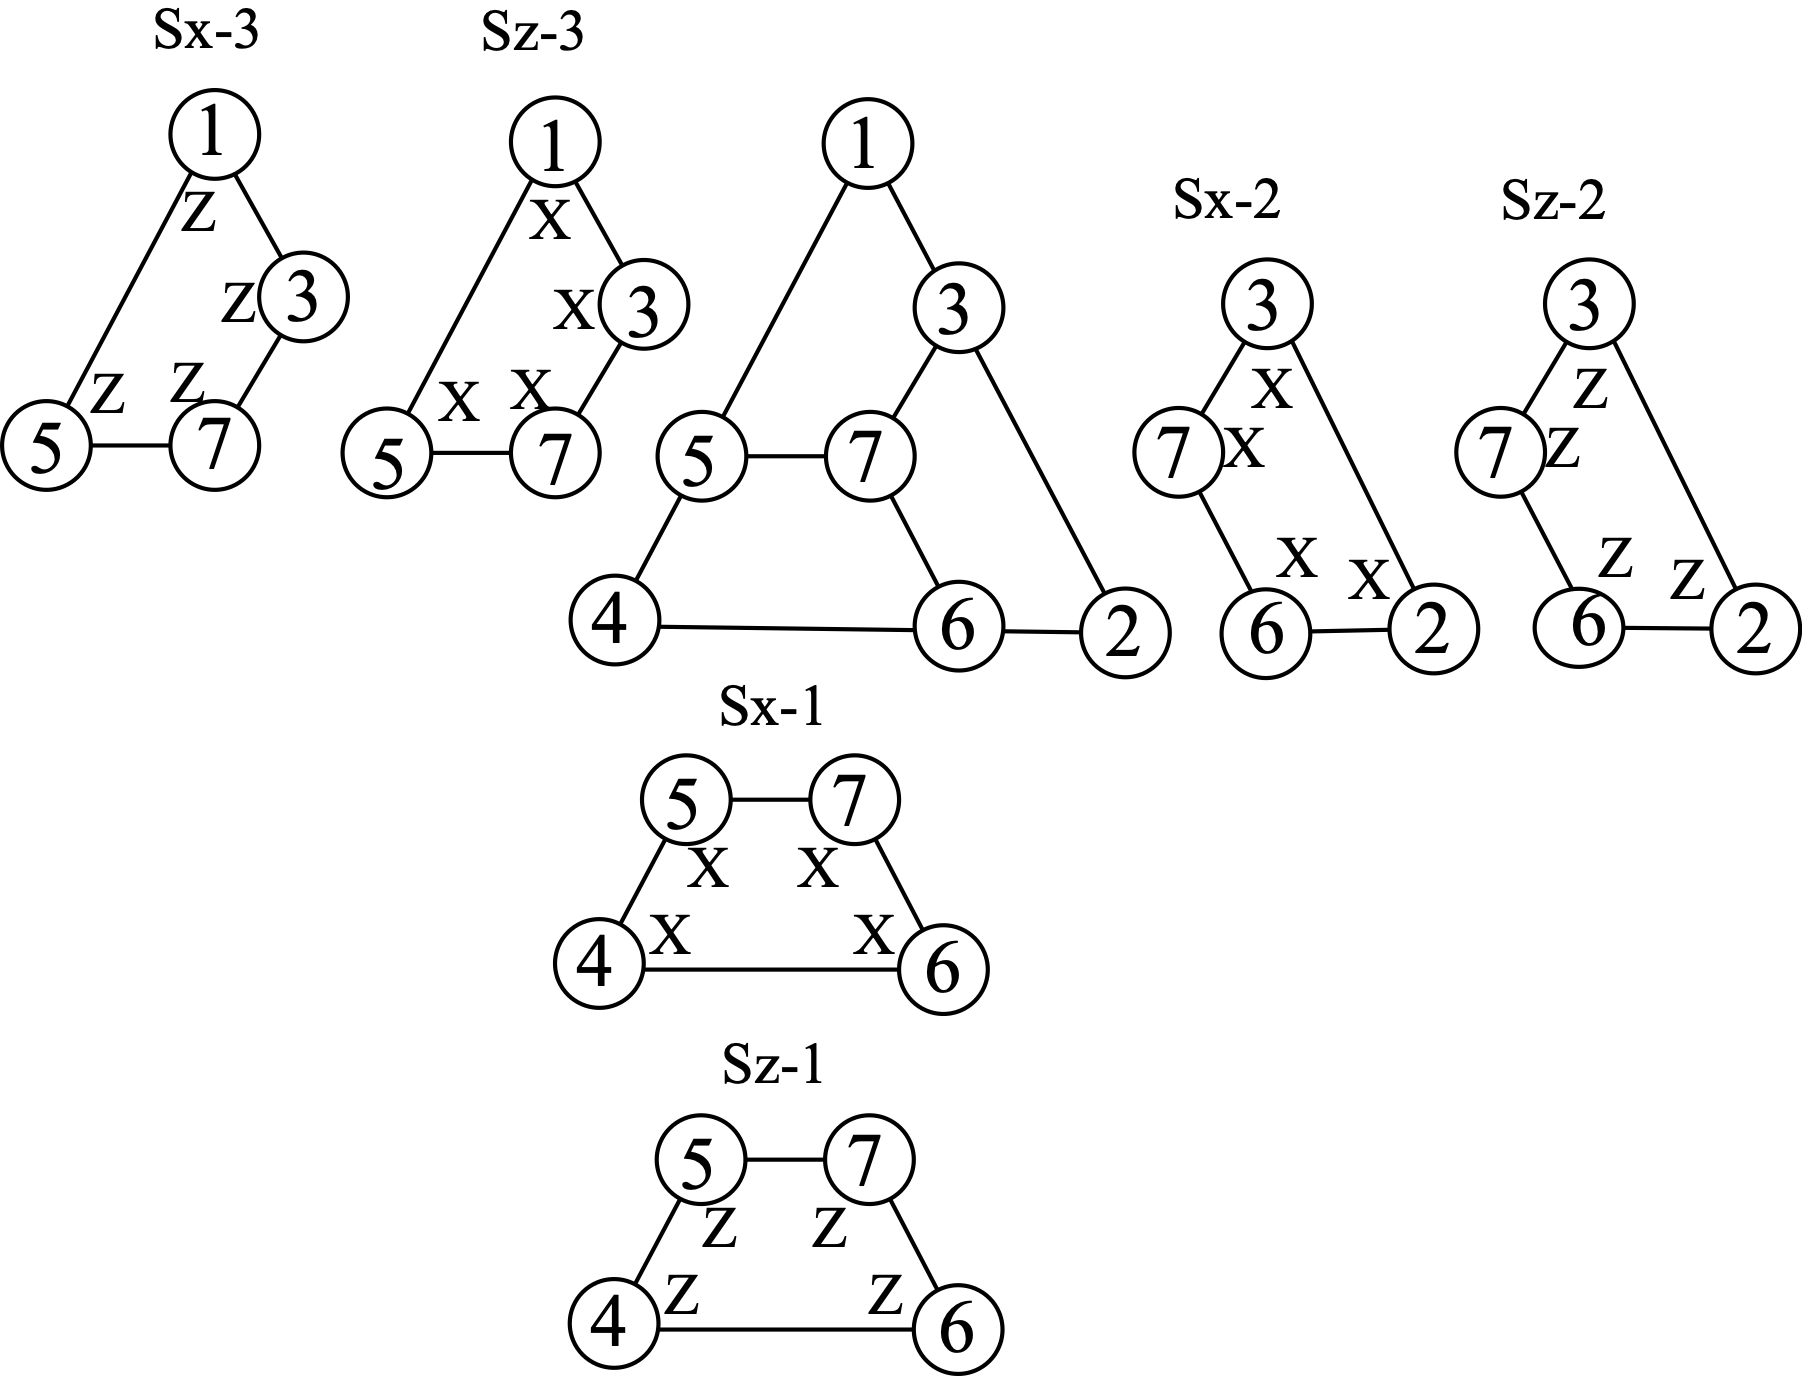

In [ ]:
# このセルは画像を表示するだけです。Google Colabでは実行しないでください。
from IPython.display import Image, display_png
display_png(Image("./fig/color_d3.png"))

誤りのシミュレートを行うには、復号後の誤りが論理演算子と反可換になるかどうかを確認する必要があります。
そのためには、論理演算子の基底を求める必要があります。

In [6]:
def gf2_row_echelon(mat):
    """Return row‑reduced form (mod 2) and list of pivot columns."""
    a = mat.copy().astype(np.uint8)
    m, n = a.shape
    pivots = []
    r = 0
    for c in range(n):
        # Find a pivot in (or under) row r with 1 in column c
        pivot = None
        for i in range(r, m):
            if a[i, c]:
                pivot = i
                break
        if pivot is None:
            continue
        # Swap so that pivot row == r
        if pivot != r:
            a[[r, pivot]] = a[[pivot, r]]
        # Eliminate other 1s in this column
        for i in range(m):
            if i != r and a[i, c]:
                a[i] ^= a[r]
        pivots.append(c)
        r += 1
        if r == m:
            break
    return a, pivots

def gf2_rank(mat):
    return len(gf2_row_echelon(mat)[1])

def gf2_nullspace(mat):
    """Return a list of basis vectors for the right‑nullspace (mod 2)."""
    m, n = mat.shape
    rref, pivots = gf2_row_echelon(mat)
    free_cols = [c for c in range(n) if c not in pivots]
    basis = []
    for f in free_cols:
        v = np.zeros(n, dtype=np.uint8)
        v[f] = 1
        for row, p in enumerate(pivots):
            if rref[row, f]:
                v[p] = 1
        basis.append(v)
    return basis

def is_in_span(basis, v):
    """
    Return True iff v is in the GF(2) row-span of 'basis'.
    'basis' can be a list of 1-D uint8 arrays OR a 2-D NumPy array.
    """
    # Normalise to list of rows
    if isinstance(basis, np.ndarray):
        basis = [row for row in basis if np.any(row)]
    if len(basis) == 0:
        return not np.any(v)
    B = np.vstack(basis).astype(np.uint8)
    rank_B      = gf2_rank(B)
    rank_aug    = gf2_rank(np.vstack([B, v]))
    return rank_aug == rank_B

def logical_bases(Hx, Hz):
    """
    Return **independent** bases for logical X- and Z-operators.

    We build them incrementally: whenever a null-space vector doesn’t yet sit
    in the current span, we keep it and extend the span.  This guarantees the
    correct number (k) of logical operators.
    """
    null_X = gf2_nullspace(Hz)     # candidates for logical X
    null_Z = gf2_nullspace(Hx)     # candidates for logical Z

    row_X = gf2_row_echelon(Hx)[0]
    row_Z = gf2_row_echelon(Hz)[0]
    row_X_basis = [row_X[i] for i in range(row_X.shape[0]) if np.any(row_X[i])]
    row_Z_basis = [row_Z[i] for i in range(row_Z.shape[0]) if np.any(row_Z[i])]

    lx_basis, span_X = [], row_X_basis.copy()
    for v in null_X:
        if not is_in_span(span_X, v):
            lx_basis.append(v)
            span_X.append(v)

    lz_basis, span_Z = [], row_Z_basis.copy()
    for v in null_Z:
        if not is_in_span(span_Z, v):
            lz_basis.append(v)
            span_Z.append(v)

    return lx_basis, lz_basis

In [7]:
lx, lz = logical_bases(Hx, Hz)
print("Logical X-basis:" + str(lx))
print("Logical Z-basis:" + str(lz))

Logical X-basis:[array([1, 1, 1, 0, 0, 0, 0], dtype=uint8)]
Logical Z-basis:[array([1, 1, 1, 0, 0, 0, 0], dtype=uint8)]


それでは誤りのシミュレーションを行いましょう。

In [8]:
# パウリ誤りをサンプリングする関数
def sample_pauli_error(n, p):
    """Sample a random n‑qubit Pauli error under depolarising noise prob p."""
    a = np.zeros(n, dtype=np.uint8)  # X components
    b = np.zeros(n, dtype=np.uint8)  # Z components
    rand = np.random.random(n)
    error_qubits = rand < p
    # For qubits that suffer an error, choose X, Y, or Z with equal probability
    choices = np.random.randint(0, 3, size=n)
    a[error_qubits & (choices == 0)] = 1           # X
    b[error_qubits & (choices == 1)] = 1           # Z
    a[error_qubits & (choices == 2)] = 1           # Y has X+Z
    b[error_qubits & (choices == 2)] = 1
    return a, b
# 復号後に残された誤りが論理演算子と反可換になるかどうかを確認する関数。
# 反可換であれば論理誤りが発生したことになります。
def is_logical_error(a, b, lx_basis, lz_basis):
    for lx in lx_basis:
        if (b & lx).sum() % 2:  # anti‑commutes with logical X
            return True
    for lz in lz_basis:
        if (a & lz).sum() % 2:  # anti‑commutes with logical Z
            return True
    return False

復号にはBP+OSDと呼ばれるアルゴリズムを使用します。
詳細が気になる方は[論文](https://arxiv.org/abs/2005.07016)をチェックしてみてください。

In [9]:
from ldpc import BpOsdDecoder

def make_decoder(H, p_error):
    """BP+OSDデコーダを初期化"""
    return BpOsdDecoder(H, error_rate=float(p_error), max_iter=50, osd_order=0)

def decode_syndrome(decoder, syndrome, p_error, n):
    """BP+OSDで符号語を復号（LLRは初期設定済み）"""
    return decoder.decode(syndrome).astype(np.uint8)

In [10]:
def decode_css_error(a, b, Hx, Hz, decoder_x, decoder_z, p_error, n):
    sx = Hz @ a % 2
    sz = Hx @ b % 2
    est_a = decode_syndrome(decoder_x, sx, p_error, n)
    est_b = decode_syndrome(decoder_z, sz, p_error, n)

    a_corr = (a + est_a) % 2
    b_corr = (b + est_b) % 2

    return a_corr, b_corr

In [11]:
def simulate_css_with_decoding(Hx, Hz, p_list, shots_per_point=20000, seed=None):
    """CSS符号の復号付き論理誤り率シミュレーション"""
    if seed is not None:
        np.random.seed(seed)

    n = Hx.shape[1]
    lx_basis, lz_basis = logical_bases(Hx, Hz)

    logical_rates = []
    fails_list = []

    for p_error in tqdm(p_list, desc="Physical error rate", unit="p"):
        # 毎回、誤り率pに応じたデコーダを作成
        decoder_x = make_decoder(Hz, p_error)
        decoder_z = make_decoder(Hx, p_error)

        fails = 0
        for _ in range(shots_per_point):
            a, b = sample_pauli_error(n, p_error)
            a_corr, b_corr = decode_css_error(a, b, Hx, Hz, decoder_x, decoder_z, p_error, n)
            if is_logical_error(a_corr, b_corr, lx_basis, lz_basis):
                fails += 1
        logical_rates.append(fails / shots_per_point)
        fails_list.append(fails)

    return np.array(logical_rates), np.array(fails_list)

In [12]:
print(np.logspace(-4, -1, 15))

[0.0001     0.00016379 0.00026827 0.0004394  0.00071969 0.00117877
 0.0019307  0.00316228 0.00517947 0.00848343 0.01389495 0.02275846
 0.03727594 0.06105402 0.1       ]


In [13]:
shots = 200000
p_vals = np.logspace(-4, -1, 15)
logical_rates, fails_list = simulate_css_with_decoding(Hx, Hz, p_vals, shots_per_point=shots, seed=42)

Physical error rate: 100%|██████████| 15/15 [00:34<00:00,  2.28s/p]


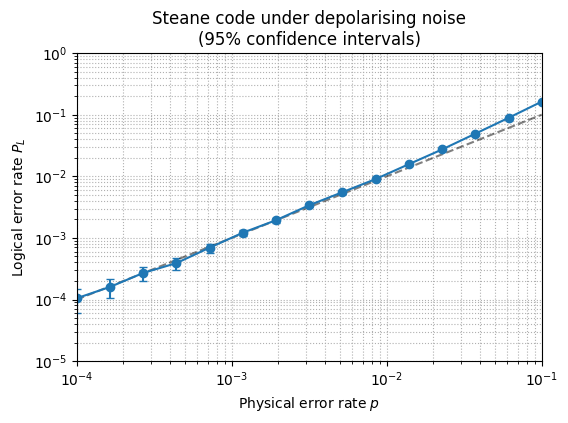

In [14]:
# 標準誤差（SE）と95%信頼区間
se = np.sqrt(logical_rates * (1 - logical_rates) / shots)
ci95 = 1.96 * se  # 95%信頼区間

# プロット
plt.figure(figsize=(6, 4))
plt.errorbar(p_vals, logical_rates, yerr=ci95, fmt='o-', capsize=3)
# 直線y=xを描画
plt.plot([1e-4, 1e-1], [1e-4, 1e-1], 'k--', label='y=x', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.xlim(1e-4, 1e-1)
plt.xlabel('Physical error rate $p$')
plt.ylabel('Logical error rate $P_L$')
plt.title('Steane code under depolarising noise\n(95% confidence intervals)')
plt.grid(True, which='both', ls=':')
plt.show()

# 最終課題

## 注意
最終課題は量子誤り訂正符号(演習ベース)と量子インターネット(論述ベース)の選択式です。どちらか一つを提出してください。

### 量子誤り訂正符号に関する演習ベースの課題
$d=5$の色符号のノイズをシミュレーションし、$d=3$(Steane符号)の結果と一緒にプロットせよ。

色符号は3色彩色可能な平面で定義される符号で、量子誤り訂正の研究において重要な役割を果たす。色符号の定義と性質については、以下の[リンク](https://errorcorrectionzoo.org/c/2d_color)を参照すること。

セル15に示す符号距離$d=5$の色符号のノイズシミュレーションを行なうこと。Steane符号と同様に、各頂点が符号語を構成する物理量子ビットであり、各面に対して、面を構成するすべての量子ビットに対するXスタビライザとZスタビライザを持つ。

加点要素(任意)
- [Error Correction Zoo](https://errorcorrectionzoo.org/)に載っている任意の量子誤り訂正符号をシミュレートする(LDPC-CSS符号ならばBP-OSDがそのまま使用可能)。
- $d=3,5,7,9...$と距離を一般化して比較する
- BP-OSD以外の復号アルゴリズムを用いる
- BP-OSDのOSD部分が性能にどの程度寄与するか確かめる
- 符号の性能や閾値、実用的性質、理論的性質に関する考察
- depolarizing noise 以外のノイズのシミュレーション(circuit-levelなど、stim推奨)

Tips
- ショット数を多くすると信頼区間を小さくできるがシミュレーション時間が長くなる。
  - 特に物理誤り率が小さくなってくると多くのショット数が必要になる
- シミュレーションの結果がおかしい際は一旦復号せずに結果をプロットしてみると良い。
- 論理誤りの判定には、残された誤りが符号の論理演算子と反可換になっているかをチェックしている。
- Steane符号は符号距離3の色符号である。
- 色符号のパリティ検査行列の$Hx$と$Hz$は等しい。

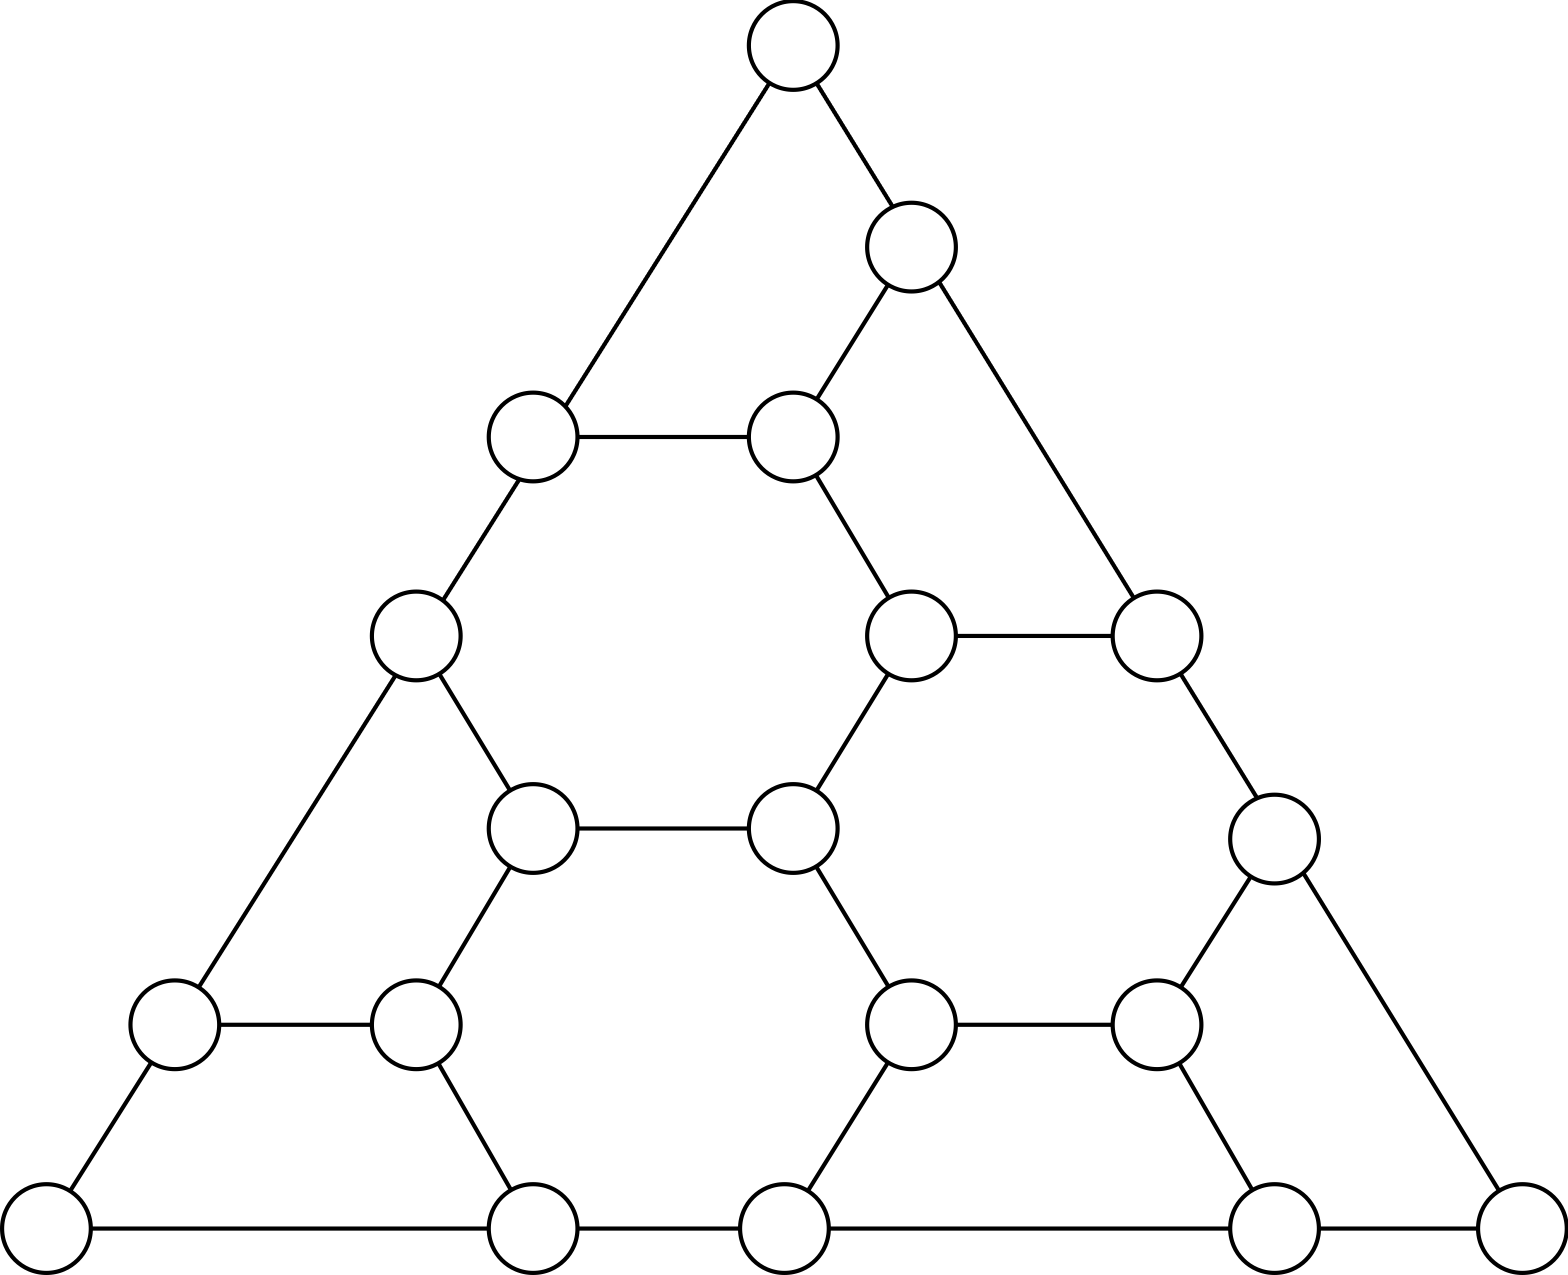

In [ ]:
# このセルは画像を表示するだけです。Google Colabでは実行しないでください。
display_png(Image("./fig/color_d5.png"))

In [16]:
# 複数の結果をプロットする際に使用する関数
def plot_multiple_results(p_vals, labels, logical_rates_list, shots):
    """
    Plot multiple results on the same graph.
    
    p_vals: List of physical error rates.
    labels: List of labels for each set of results.
    logical_rates_list: List of lists of logical error rates.
    shots: Number of shots used for each rate.
    """
    plt.figure(figsize=(6, 4))
    
    for i in range(len(labels)):
        label = labels[i]
        logical_rates = logical_rates_list[i]
        se = np.sqrt(logical_rates * (1 - logical_rates) / shots)
        ci95 = 1.96 * se  # 95% confidence interval
        plt.errorbar(p_vals, logical_rates, yerr=ci95, fmt='o-', label=label, capsize=3)

    plt.plot([1e-4, 1e-1], [1e-4, 1e-1], 'k--', label='y=x', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-8, 1)
    plt.xlim(1e-4, 1e-1)
    plt.xlabel('Physical error rate $p$')
    plt.ylabel('Logical error rate $P_L$')
    plt.title('XXX code under depolarising noise\n(95% confidence intervals)')
    plt.grid(True, which='both', ls=':')
    plt.legend()
    plt.show()

## 解答例

In [ ]:
import numpy as np
# Steane [[19,1,5]] code
H_5 = np.array(
            # 画像を元にパリティ検査行列を作成してください。
              , dtype=np.uint8)
Hx_5 = H_5.copy()
Hz_5 = H_5.copy()

In [18]:
lx, lz = logical_bases(Hx, Hz)
print("Logical X-basis:" + str(lx))
print("Logical Z-basis:" + str(lz))

Logical X-basis:[array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=uint8)]
Logical Z-basis:[array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=uint8)]


In [ ]:
shots = 200000
p_vals = np.logspace(-4, -1, 15)
logical_rates, fails_list = simulate_css_with_decoding(Hx_5, Hz_5, p_vals, shots_per_point=shots, seed=25)

Physical error rate: 100%|██████████| 15/15 [00:41<00:00,  2.75s/p]


In [ ]:
# 標準誤差（SE）と95%信頼区間
se = np.sqrt(logical_rates * (1 - logical_rates) / shots)
ci95 = 1.96 * se  # 95%信頼区間

# プロット
plt.figure(figsize=(6, 4))
plt.errorbar(p_vals, logical_rates, yerr=ci95, fmt='o-', capsize=3)
# 直線y=xを描画
plt.plot([1e-4, 1e-1], [1e-4, 1e-1], 'k--', label='y=x', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.xlim(1e-4, 1e-1)
plt.xlabel('Physical error rate $p$')
plt.ylabel('Logical error rate $P_L$')
plt.title('Color code under depolarising noise\n(95% confidence intervals)')
plt.grid(True, which='both', ls=':')
plt.show()

比較プロットの作成

In [ ]:
shots = 2000000
p_vals = np.logspace(-5, -1, 20)

# Steane [[7,1,3]] code
H_3 = np.array([[0,0,0,1,1,1,1],
              [0,1,1,0,0,1,1],
              [1,0,1,0,1,0,1]], dtype=np.uint8)
Hx_3 = H_3.copy()
Hz_3 = H_3.copy()
logical_rates_3, fails_list_3 = simulate_css_with_decoding(Hx_3, Hz_3, p_vals, shots_per_point=shots, seed=22)

# d=5 color code
logical_rates_5, fails_list_5 = simulate_css_with_decoding(Hx_5, Hz_5, p_vals, shots_per_point=shots, seed=42)

Physical error rate: 100%|██████████| 20/20 [08:44<00:00, 26.21s/p]


In [ ]:
print(logical_rates_3)
print(logical_rates_5)

In [ ]:
plot_multiple_results(p_vals=p_vals, labels=["d=3","d=5"], logical_rates_list=[logical_rates_3, logical_rates_5], shots=shots)